# Train MNIST CNN by using tf.keras

## 1. Import libs

In [2]:
# Using TensorFlow backend
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.optimizers import RMSprop

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

np.random.seed(2)
tf.random.set_seed(2)

## 2. Data preparation¶

In [3]:
!pwd

/Users/zhenting/INFO5100_002304821_ChenTingKuo/Finalproject


### 2.1 Load data

In [4]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

# label 0-9
Y_train = train["label"]
# Drop lebel column
X_train = train.drop(labels = ["label"], axis = 1)
del train

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("test shape:", test.shape)

X_train shape: (42000, 784)
Y_train shape: (42000,)
test shape: (28000, 784)


### 2.2 Check for null and missing values

In [5]:
X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Normalization and Reshape

In [6]:
# Normalize
X_train = X_train.astype('float32') / 255.0  # Normalize to [0,1]
test = test.astype('float32') / 255.0

# Reshape
# (42000, 28, 28) -> Add channel dimension (-1, 28, 28, 1), -1 is number of images = 42000, channel = 1(gray)
# NHWC：(Batch size, Height, Width, Channels)
X_train = X_train.values.reshape(-1, 28, 28, 1) # .values: df to np array
test = test.values.reshape(-1, 28, 28, 1)

### 2.5 Label encoding

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)
Y_train.shape

(42000, 10)

### 2.6 Split train and valdiation dataset

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

print("X_train shape:", X_train.shape)  # (33600, 28, 28, 1)
print("X_val shape:", X_val.shape)      # (8400, 28, 28, 1)
print("y_train shape:", Y_train.shape)  # (33600, 10)
print("y_val shape:", Y_val.shape)      # (8400, 10)

X_train shape: (37800, 28, 28, 1)
X_val shape: (4200, 28, 28, 1)
y_train shape: (37800, 10)
y_val shape: (4200, 10)


In [7]:
# def check_for_duplicates(X_train, X_val):
#     train_set = set(tuple(x.flatten()) for x in X_train)
#     val_set = set(tuple(x.flatten()) for x in X_val)
#     intersection = train_set.intersection(val_set)
#     return len(intersection)

# duplicates = check_for_duplicates(X_train, X_val)
# duplicates

## CNN

### 3.1 Define the model

In [9]:
model = models.Sequential([
    layers.Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (5, 5), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    layers.Dropout(0.1),
    
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dropout(0.3),
    
    layers.Dense(10, activation='softmax')
])

2025-04-15 12:11:43.089164: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-15 12:11:43.089763: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-15 12:11:43.089900: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-15 12:11:43.090269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-15 12:11:43.090638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 3.2 Set the optimizer

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0

In [11]:
# Dynamically adjust lr during the training process, 
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3, # after 3 epochs
    verbose=1, # log
    factor=0.5,
    min_lr=0.00001 # avoid lr too small and stop learning
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

### 3.3 Data augmentation

In [12]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=3,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.02,  # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

datagen.fit(X_train)

### 3.4 Train

In [11]:
epochs = 30
batch_size = 86
history = model.fit(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=(X_val, Y_val),
                                 verbose=1,
                                 steps_per_epoch=X_train.shape[0] // batch_size, # epoch steps, 33600//86=390
                                 callbacks=[lr_reduction])

Epoch 1/30


2025-04-14 14:54:53.954246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-04-14 14:54:53.978553: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-04-14 14:54:54.380355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8503

2025-04-14 14:55:11.198904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4200,10]
	 [[{{node Placeholder/_11}}]]
2025-04-14 14:55:11.199003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4200,10]
	 [[{{node Placeholder/_11}}]]
2025-04-14 14:55:11.252075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - 18s 36ms/step - loss: 0.4924 - accuracy: 0.8503 - val_loss: 0.4412 - val_accuracy: 0.8757 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - 15s 34ms/step - loss: 0.1199 - accuracy: 0.9679 - val_loss: 0.0512 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - 15s 34ms/step - loss: 0.0830 - accuracy: 0.9770 - val_loss: 0.0429 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 4/30
439/439 [==============================] - 15s 34ms/step - loss: 0.0654 - accuracy: 0.9815 - val_loss: 0.0419 - val_accuracy: 0.9876 - lr: 1.0000e-04
Epoch 5/30
439/439 [==============================] - 15s 35ms/step - loss: 0.0554 - accuracy: 0.9845 - val_loss: 0.0358 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 6/30
439/439 [==============================] - 15s 34ms/step - loss: 0.0502 - accuracy: 0.9852 - val_loss: 0.0313 - val_accuracy: 0.9921 - lr: 1.0000e-04
Epoch 7/30
439/439 [=========================

## 4. Evaluate the model

### 4.1 Training and validation metric

In [12]:
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
val_accuracy

  9/132 [=>............................] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000    

2025-04-14 15:03:46.908693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4200,10]
	 [[{{node Placeholder/_11}}]]
2025-04-14 15:03:46.909130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4200,10]
	 [[{{node Placeholder/_11}}]]


132/132 [==============================] - 1s 9ms/step - loss: 0.0186 - accuracy: 0.9940


0.9940476417541504

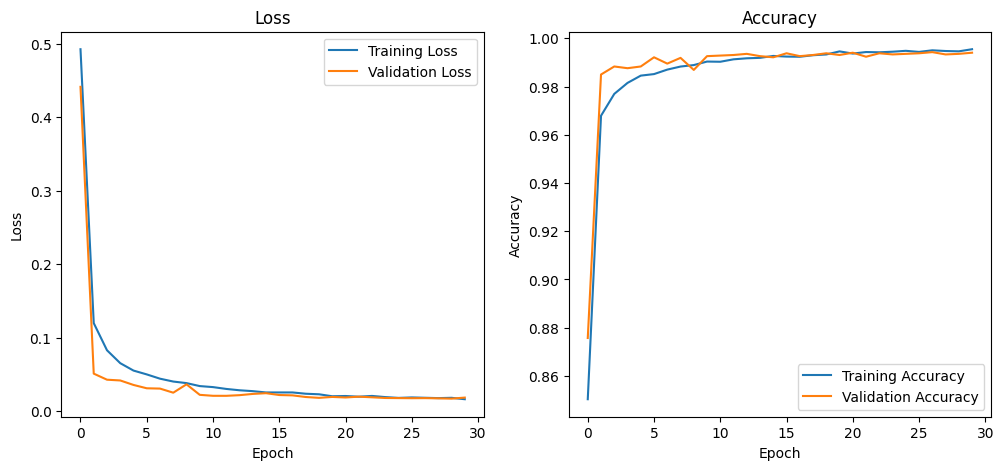

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4.2 Confusion matrix

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

 22/132 [====>.........................] - ETA: 0s

2025-04-14 15:13:51.365234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4200,28,28,1]
	 [[{{node Placeholder/_10}}]]
2025-04-14 15:13:51.365349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4200,28,28,1]
	 [[{{node Placeholder/_10}}]]


132/132 [==============================] - 1s 4ms/step


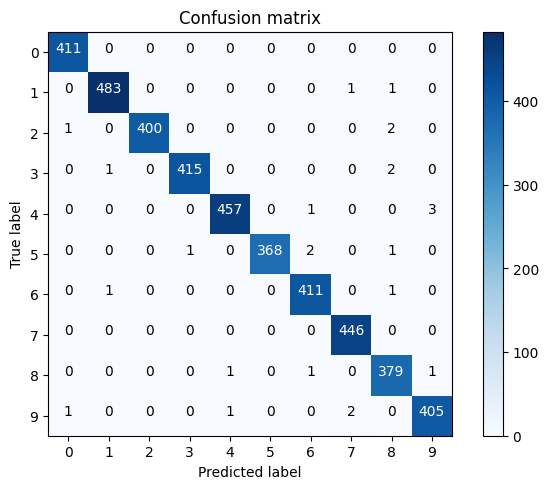

In [26]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## 5. Save Model

In [15]:
!pwd

/Users/zhenting/INFO5100_002304821_ChenTingKuo/Finalproject


In [16]:
model.save('./model/mnist_cnn_keras.h5')

## 6. .tflite model inference test

In [3]:
from PIL import Image
import numpy as np
import tensorflow as tf
import io
from flask import Flask, request, jsonify

In [4]:
!pwd

/Users/zhenting/INFO5100_002304821_ChenTingKuo/Finalproject/model


In [6]:
image_file = "../data/img_4.jpg"
image = Image.open(image_file).convert("L").resize((28, 28))
image

In [3]:
# pre process
image_array = np.array(image, dtype=np.float32) / 255.0
image_array = image_array.reshape(1, 28, 28, 1)

In [4]:
# load model
interpreter = tf.lite.Interpreter(model_path="./mnist_cnn_keras.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details() # [1, 28, 28, 1], dtype=int32 
output_details = interpreter.get_output_details() # [1, 10], dtype=int32

input_details[0]

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
VERBOSE: Replacing 5 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 7 partitions for the whole graph.
INFO: Successfully applied the default TensorFlow Lite delegate indexed at 0.
 *NOTE*: because a delegate has been applied, the precision of computations should be unchanged, but the exact output tensor values may have changed. If such output values are checked in your code, like in your tests etc., please consider increasing error tolerance for the check.


{'name': 'conv2d_input',
 'index': 0,
 'shape': array([ 1, 28, 28,  1], dtype=int32),
 'shape_signature': array([-1, 28, 28,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [5]:
# inference
interpreter.set_tensor(input_details[0]['index'], image_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

array([[6.1190070e-07, 5.1832703e-06, 3.4771963e-06, 5.2841233e-07,
        9.9915743e-01, 5.6046551e-06, 1.6364277e-06, 7.5627351e-05,
        7.9282639e-05, 6.7065575e-04]], dtype=float32)

In [6]:
prediction = int(np.argmax(output_data))
confidence = float(output_data[0][prediction])
prediction, confidence

(4, 0.9991574287414551)